#### Context  <br>
BankSim is an agent-based simulator of bank payments based on a sample of aggregated transactional data provided by a bank in Spain. The main purpose of BankSim is the generation of synthetic data that can be used for fraud detection research. Statistical and a Social Network Analysis (SNA) of relations between merchants and customers were used
to develop and calibrate the model. Our ultimate goal is for BankSim to be usable to model relevant scenarios that combine normal payments and injected known fraud signatures. The data sets generated by BankSim contain no personal information or disclosure of legal and private customer transactions. Therefore, it can be shared by academia, and others, to develop and reason about fraud detection methods. Synthetic data has the added benefit of being easier to acquire, faster and at less cost, for experimentation even for those that have access to their own data. We argue that BankSim generates data that usefully approximates the relevant aspects of the real data.

#### Content  <br>
We ran BankSim for 180 steps (approx. six months), several times and calibrated the parameters in order to obtain a distribution that get close enough to be reliable for testing. We collected several log files and selected the most accurate. We injected thieves that aim to steal an average of three cards per step and perform about two fraudulent transactions per day. We produced 594643 records in total. Where 587443 are normal payments and 7200 fraudulent transactions. Since this is a randomised simulation the values are of course not identical to original data.

In [12]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [13]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Importing Pandas and NumPy
import pandas as pd, numpy as np

In [15]:
# Importing all datasets
fraud_detection = pd.read_csv("C:/Users/HP/Desktop/Fraud_Detection/fraud_detection.csv")
fraud_detection.head(4)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0


In [16]:
fraud_detection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [17]:
fraud_detection.shape

(594643, 10)

##### <u> FEATURE ENGINEERING </u>

### Treating the `Missing` Values

Data That can be missing can be of two types : <br>
    1) Continuous Data <br>
    2) Discreate Or Categorical Data <br>
    
The Types of `missing` can be of mentioned types : <br>
1) <b>MCAR</b> - Missing Completely At Random <br>
If the probability of being `missing` is same for all the observations.<br>
2) <b>MNAR</b> - Missing Not At Random <br>
There is some relationship between the missing data <br>
3) <b>MAR</b> - Missing At Random <br>


In [18]:
fraud_detection.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

##### There is no `missing values` for this data . Incase if there is any missing values , we can use the mentioned below function for imputation

In [19]:
def impute_nan(df,variable,median):
    df[variable+"_median"]=df[variable].fillna(median)
    df[variable+"_random"]=df[variable]
    ##It will have the random sample to fill the na
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    ##pandas need to have same index in order to merge the dataset
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable+'_random']=random_sample

In [20]:
fraud_detection.head(4)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0


In [21]:
fraud_detection.gender = fraud_detection.gender.astype('category').cat.codes

In [22]:
fraud_detection.category = fraud_detection.category.astype('category').cat.codes

In [23]:
fraud_detection.customer = fraud_detection.customer.astype('category').cat.codes
fraud_detection.merchant = fraud_detection.merchant.astype('category').cat.codes

In [24]:
fraud_detection.head(3)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,210,'4',2,'28007',30,'28007',12,4.55,0
1,0,2753,'2',2,'28007',30,'28007',12,39.68,0
2,0,2285,'4',1,'28007',18,'28007',12,26.89,0


In [25]:
fraud_detection.age = fraud_detection.age.str.replace('[\'\,]', '', regex=True)

In [26]:
fraud_detection.zipcodeOri = fraud_detection.zipcodeOri.str.replace('[\'\,]', '', regex=True)

In [27]:
fraud_detection.zipMerchant = fraud_detection.zipMerchant.str.replace('[\'\,]', '', regex=True)

In [28]:
fraud_detection.dtypes


step             int64
customer         int16
age             object
gender            int8
zipcodeOri      object
merchant          int8
zipMerchant     object
category          int8
amount         float64
fraud            int64
dtype: object

In [29]:
fraud_detection["age"] = pd.to_numeric(fraud_detection["age"], errors='ignore')

In [30]:
fraud_detection["zipcodeOri"] = pd.to_numeric(fraud_detection["zipcodeOri"], errors='coerce')

In [31]:
fraud_detection["zipMerchant"] = pd.to_numeric(fraud_detection["zipMerchant"], errors='coerce')

In [32]:
fraud_detection.head(3)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,210,4,2,28007,30,28007,12,4.55,0
1,0,2753,2,2,28007,30,28007,12,39.68,0
2,0,2285,4,1,28007,18,28007,12,26.89,0


In [33]:
fraud_detection.age.value_counts()

2    187310
3    147131
4    109025
5     62642
1     58131
6     26774
0      2452
U      1178
Name: age, dtype: int64

### HERE 'U'  and '0' stands for error data. Drop the data

In [34]:
fraud_detection = fraud_detection[~(fraud_detection.age == '0')]

In [35]:
fraud_detection = fraud_detection[~(fraud_detection.age == 'U')]

In [36]:
fraud_detection.age.value_counts()

2    187310
3    147131
4    109025
5     62642
1     58131
6     26774
Name: age, dtype: int64

In [37]:
X = fraud_detection.drop(columns="fraud")

In [38]:
Y = fraud_detection["fraud"]

In [39]:
fraud_detection.columns

Index(['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant',
       'zipMerchant', 'category', 'amount', 'fraud'],
      dtype='object')

In [40]:
fraud_detection.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

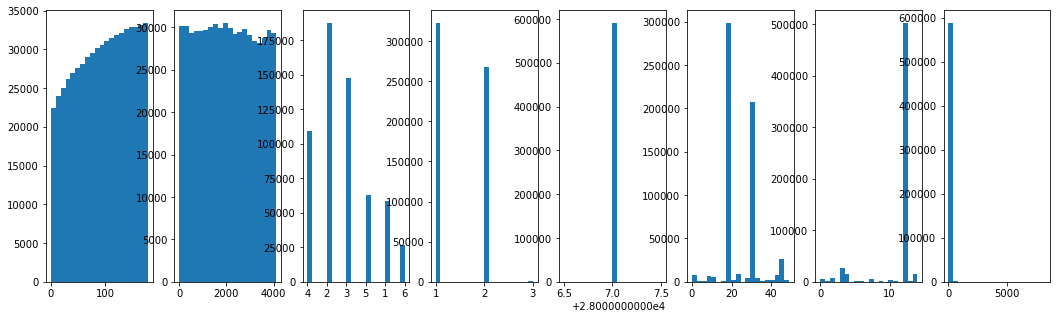

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5))
plt.subplot(1,8,1)
plt.hist(fraud_detection['step'],bins=20)
plt.subplot(1,8,2)
plt.hist(fraud_detection['customer'],bins=20)
plt.subplot(1,8,3)
plt.hist(fraud_detection['age'],bins=20)
plt.subplot(1,8,4)
plt.hist(fraud_detection['gender'],bins=20)
plt.subplot(1,8,5)
plt.hist(fraud_detection['zipcodeOri'],bins=20)
plt.subplot(1,8,6)
plt.hist(fraud_detection['merchant'],bins=20)
plt.subplot(1,8,7)
plt.hist(fraud_detection['category'],bins=20)
plt.subplot(1,8,8)
plt.hist(fraud_detection['amount'],bins=20)

plt.show()

In [42]:
# choosing all the numerical variables as independent variables (classifier can only take numerical input)
# dropping two variable funded_amnt as we have created new variable transformation based on it 
X = fraud_detection.drop(columns = "fraud")
Y = fraud_detection["fraud"]

#splitting the dataset in train and test datasets using a split ratio of 70:30

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [43]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(413709, 9) (413709,) (177304, 9) (177304,)


#### FEATURE  SELECTION

In [44]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [45]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model=ExtraTreesClassifier()
model.fit(X_train,y_train)

ExtraTreesClassifier()

In [46]:
print(model.feature_importances_)


[0.07790335 0.07974806 0.03347501 0.00642493 0.         0.20321823
 0.         0.16733023 0.43190019]


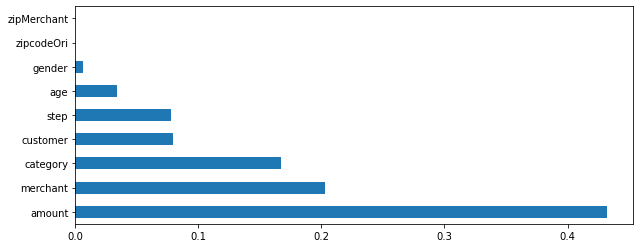

In [47]:
plt.figure(figsize = [10,4])
ranked_features=pd.Series(model.feature_importances_,index=X_train.columns)
ranked_features.nlargest(10).plot(kind='barh')
plt.show()

### Correlation - To Check `Multicollinearity`

In [48]:
X_train.corr()

,step,customer,gender,zipcodeOri,merchant,zipMerchant,category,amount
step,1.000000,0.002905,0.000545,NaN,-0.155699,NaN,-0.018231,-0.007801
customer,0.002905,1.000000,-0.007449,NaN,0.013391,NaN,0.000175,0.004658
gender,0.000545,-0.007449,1.000000,NaN,-0.007365,NaN,0.006780,-0.012025
zipcodeOri,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
merchant,-0.155699,0.013391,-0.007365,NaN,1.000000,NaN,-0.247635,0.066526
zipMerchant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,-0.018231,0.000175,0.006780,NaN,-0.247635,NaN,1.000000,-0.095956
amount,-0.007801,0.004658,-0.012025,NaN,0.066526,NaN,-0.095956,1.000000


<AxesSubplot:>

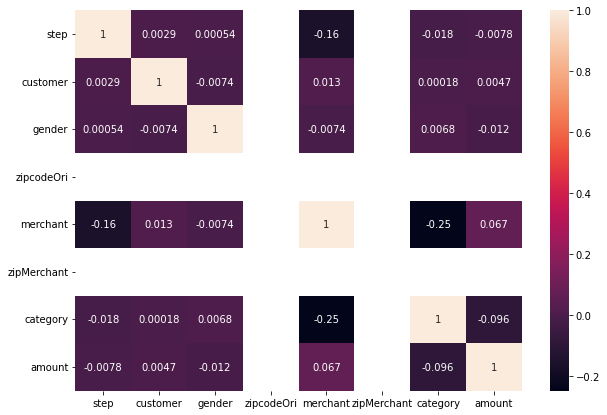

In [49]:
import seaborn as sns
corr=X_train.corr()
top_features=corr.index
plt.figure(figsize=(10,7))
sns.heatmap(X_train[top_features].corr(),annot=True)


### Reduction Of `Multi Collinearity`

In [50]:
threshold=0.6

In [51]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [52]:
correlation(X_train,threshold)

set()

In [53]:
X.columns

Index(['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant',
       'zipMerchant', 'category', 'amount'],
      dtype='object')

In [54]:
X.drop(columns="zipcodeOri", inplace=True)

In [55]:
X.drop(columns="zipMerchant", inplace=True)

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [57]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(413709, 7) (413709,) (177304, 7) (177304,)


#### PIPELINE CREATION

In [58]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [59]:
###! pip install xgboost

In [60]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler

In [61]:
pipeline_randomforest=Pipeline([('scalar3',RobustScaler()),
                     ('pca3',PCA(n_components=2)),
                     ('rf_classifier',RandomForestClassifier())])

In [62]:
pipeline_gradient_boost=Pipeline([('scalar4',RobustScaler()),
                     ('pca4',PCA(n_components=2)),
                     ('gb_classifier',GradientBoostingClassifier())])

In [63]:
pipeline_XGboost=Pipeline([('scalar5',RobustScaler()),
                          ('pca5',PCA(n_components=2)),
                          ('xgb_classifier',XGBClassifier())])

In [64]:
## LEts make the list of pipelines
pipelines = [pipeline_randomforest,pipeline_gradient_boost,pipeline_XGboost]

In [65]:
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [66]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'RandomForest', 1: 'Gradient Boost', 2: 'Extreme Gradient Boost'}

# Fit the pipelines
for pipe in pipelines:
	pipe.fit(X_train, y_train)

[13:57:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [67]:
for i,model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i],model.score(X_test,y_test)))

RandomForest Test Accuracy: 0.9952341740739069
Gradient Boost Test Accuracy: 0.9948562920182286
Extreme Gradient Boost Test Accuracy: 0.9955612958534494


In [68]:
y_test.value_counts()

0    175227
1      2077
Name: fraud, dtype: int64

In [69]:
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train, y_train)
preds = gb.predict(X_test)

In [70]:
from sklearn import metrics

In [71]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_test, preds)
print(confusion)

[[175060    167]
 [   578   1499]]


In [72]:
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}

In [73]:
from sklearn.model_selection import RandomizedSearchCV

In [74]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 5, 
                               cv = 4, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)


In [75]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [130, 180, 230]},
                   random_state=42, verbose=2)

In [76]:
rf_random.best_params_

{'n_estimators': 130,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

In [77]:
best_random_grid=rf_random.best_estimator_

In [78]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred=best_random_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[175057    170]
 [   537   1540]]
Accuracy Score 0.9960124983079908
Classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    175227
           1       0.90      0.74      0.81      2077

    accuracy                           1.00    177304
   macro avg       0.95      0.87      0.91    177304
weighted avg       1.00      1.00      1.00    177304

